In [419]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import numpy as np

In [420]:
class Policy:
    def __init__(self):
        self.alpha = 0.01
        self.policy = keras.models.Sequential([
            keras.layers.Dense(25, activation="relu", input_shape=[25]),
            keras.layers.Dense(10, activation="relu"),
            keras.layers.Dense(5, activation="softmax"),
        ])
        self.policy.compile(optimizer=Adam(learning_rate=self.alpha))
        
    def __call__(self, state):
        pi = self.policy(state)
        return pi
    
def get_obs(array, pos):
    obs = []
    i, j = pos
    for ii in range(-2, 3, 1):
        row = []
        for jj in range(-2, 3, 1):
            row.append(array[(i + ii) % len(array)][(j + jj) % len(array)])
        obs.append(row)     
    return obs

def apply_action(array, pos, action):
    i, j = pos
    if action == 0:
        array[i][j], array[i][(j + 1) % len(array)] = array[i][(j + 1) % len(array)], array[i][j]
    elif action == 1:
        array[i][j], array[i][(j - 1)] = array[i][(j - 1)], array[i][j]
    elif action == 2:
        array[i][j], array[i - 1][j] = array[i - 1][j], array[i][j]
    elif action == 3:
        array[i][j], array[i + 1][j] = array[(i + 1) % len(array)][j], array[i][j]

In [421]:
import gym
import random

In [422]:
types = [0, 1, 2]

In [423]:
obs = [[random.choice(types) for i in range(5)] for j in range(5)]
obs[2][2] = 1

In [424]:
array = np.array([[random.choice(types) for i in range(10)] for j in range(10)])

In [425]:
array

array([[1, 2, 2, 0, 1, 0, 2, 0, 2, 1],
       [2, 1, 1, 0, 1, 2, 1, 0, 1, 0],
       [1, 2, 0, 2, 1, 1, 0, 2, 0, 0],
       [0, 0, 1, 2, 1, 0, 2, 2, 2, 0],
       [2, 2, 0, 2, 1, 0, 1, 0, 1, 2],
       [2, 0, 1, 2, 1, 2, 1, 0, 0, 1],
       [1, 0, 1, 1, 0, 0, 1, 2, 1, 0],
       [1, 2, 1, 0, 2, 0, 2, 2, 0, 0],
       [1, 0, 2, 2, 0, 0, 2, 0, 2, 1],
       [1, 2, 1, 0, 2, 0, 2, 2, 0, 0]])

## Create Environment

In [577]:
from gym import Env
from gym.spaces import Discrete, Box, MultiDiscrete
import random

In [668]:
'''
Lets create environment that we have just onde predator in initial middle of table
'''
class PPEnv(Env):
    def __init__(self, L=5, time_limit=40, pos=(0, 0)):
        self.L = L
        self.pos = (self.L // 2, self.L // 2)
        self.action_space = Discrete(4)
        self.obs_shape = (5, 5)
        self.observation_space = MultiDiscrete(np.array([[3 for i in range(5)] for j in range(5)]))
        self.types = Discrete(3)
        self.array = np.array([[Discrete(2).sample() * 2 for i in range(self.L)] for j in range(self.L)])
        # Put one predator
        self.array[self.pos[0], self.pos[1]] = 1               
        self.time = 0
        self.time_limit = time_limit
    
    def get_obs(self):
        obs = []
        i, j = self.pos
        for ii in range(-2, 3, 1):
            row = []
            for jj in range(-2, 3, 1):
                row.append(self.array[(i + ii) % self.L][(j + jj) % self.L])
            obs.append(row)     
        return np.array(obs)
    
    # Jump
    def apply_action(self, action):
        i, j = self.pos
        L = self.L
        if action == 0:
            self.array[i][j], self.array[i][(j + 1) % L] = self.array[i][(j + 1) % L], self.array[i][j]
            self.pos = (i, (j + 1) % L)
        elif action == 1:
            self.array[i][j], self.array[i][(j - 1) % L] = self.array[i][(j - 1) % L], self.array[i][j]
            self.pos = (i, (j - 1) % L)
        elif action == 2:
            self.array[i][j], self.array[(i - 1) % L][j] = self.array[(i - 1) % L][j], self.array[i][j]
            self.pos = ((i - 1) % L, j)
        elif action == 3:
            self.array[i][j], self.array[(i + 1) % L][j] = self.array[(i + 1) % L][j], self.array[i][j]
            self.pos = ((i + 1) % L, j)
    
    def get_neighboors(self):
        i, j = self.pos
        adress = [
            (i, (j + 1) % self.L), 
            (i, (j - 1) % self.L), 
            ((i - 1) % self.L, j), 
            ((i + 1) % self.L, j)
        ]
        right, left, up, down = self.array[adress[0][0]][adress[0][1]], self.array[adress[1][0]][adress[1][1]], self.array[adress[2][0]][adress[2][1]], self.array[adress[3][0]][adress[3][1]]
        return [right, left, up, down]
    
    def step(self, action):
        # Get obs
        obs = self.get_obs()
        
        # Colect reward
        ngbs = [obs[2][2 + 1], obs[2][2 - 1], obs[2 - 1][2], obs[2 + 1][2]] #self.get_neighboors()
        reward = 2 ** ngbs.count(2)
        
        # Get info
        info = {}
        
        # Check if done
        if self.time >= self.time_limit:
            done = True
            return obs, reward, done, info
        else: 
            done = False
            
        # apply action
        self.apply_action(action)
        self.time += 1
        return obs, reward, done, info
    
    def render(self):
        print('-' * self.L)
        print(self.array)
        print('-' * self.L)
    
    def reset(self):
        self.pos = (self.L // 2, self.L // 2)
        self.action_space = Discrete(4)
        self.observation_space = MultiDiscrete(np.array([[3 for i in range(5)] for j in range(5)]))
        self.types = Discrete(3)
        self.array = np.array([[Discrete(2).sample() * 2 for i in range(self.L)] for j in range(self.L)])
        # Put one predator
        self.array[self.pos[0], self.pos[1]] = 1               
        self.time = 0
        return np.array(self.get_obs())

In [669]:
env = PPEnv()

In [670]:
obs = env.reset()
env.apply_action(0)

In [671]:
env.action_space.sample()

1

### Testing environment

In [626]:
render = False

In [627]:
episodes = 100
for ep in range(episodes):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        obs, rew, done, info = env.step(env.action_space.sample())
        if render:
            env.render()
        score += rew
    print(f"Ep: {ep} || Score: {score}")

Ep: 0 || Score: 115
Ep: 1 || Score: 136
Ep: 2 || Score: 86
Ep: 3 || Score: 188
Ep: 4 || Score: 180
Ep: 5 || Score: 168
Ep: 6 || Score: 64
Ep: 7 || Score: 109
Ep: 8 || Score: 174
Ep: 9 || Score: 168
Ep: 10 || Score: 76
Ep: 11 || Score: 186
Ep: 12 || Score: 113
Ep: 13 || Score: 94
Ep: 14 || Score: 174
Ep: 15 || Score: 114
Ep: 16 || Score: 172
Ep: 17 || Score: 132
Ep: 18 || Score: 192
Ep: 19 || Score: 145
Ep: 20 || Score: 87
Ep: 21 || Score: 61
Ep: 22 || Score: 160
Ep: 23 || Score: 91
Ep: 24 || Score: 166
Ep: 25 || Score: 168
Ep: 26 || Score: 114
Ep: 27 || Score: 213
Ep: 28 || Score: 92
Ep: 29 || Score: 132
Ep: 30 || Score: 112
Ep: 31 || Score: 256
Ep: 32 || Score: 160
Ep: 33 || Score: 146
Ep: 34 || Score: 110
Ep: 35 || Score: 138
Ep: 36 || Score: 168
Ep: 37 || Score: 172
Ep: 38 || Score: 72
Ep: 39 || Score: 228
Ep: 40 || Score: 134
Ep: 41 || Score: 206
Ep: 42 || Score: 128
Ep: 43 || Score: 157
Ep: 44 || Score: 104
Ep: 45 || Score: 87
Ep: 46 || Score: 137
Ep: 47 || Score: 116
Ep: 48 || Sc

In [628]:
np.array([Discrete(3)] * 25).shape

(25,)

In [629]:
MultiDiscrete(2).sample()

0

## PPO stablebaselines

In [630]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

## Treinando o modelo

In [631]:
log_path = os.path.join('Training', 'PP_0')

In [632]:
log_path

'Training\\PP_0'

In [633]:
env

## Genetic

In [634]:
env = PPEnv()

In [635]:
from tqdm import tqdm
import random

num_models = 75
num_generations = 75
nb_of_simulations = 10
fraction = 0.2

In [636]:
class NeuralModel:

    @staticmethod
    def get_random_params(obs_size, act_size):
        
#         return [
#             np.random.randn(obs_size, obs_size + 1),
#             np.zeros(obs_size + 1),
#             np.random.randn(obs_size + 1, act_size),
#             np.zeros(act_size),
#         ]
        return [
            np.random.randn(25, 25),
            np.zeros(25),
            
            np.random.randn(25, 25),
            np.zeros(25),
            
            np.random.randn(25, 4),
            np.zeros(4),
        ]
        

    def __init__(self, obs_act_sizes, params=None):
        self.obs_act_sizes = obs_act_sizes
        obs_size, act_size = self.obs_act_sizes
#         obs_size = len(env.observation_space.sample())
#         act_size = env.action_space.n
        if not params:
            params = self.get_random_params(obs_size, act_size)

        n_inputs = obs_size  # env.observation_space.shape[0]
        self.model = keras.models.Sequential([
            
#             keras.layers.Dense(obs_size + 1, activation="elu", input_shape=[n_inputs]),
#             keras.layers.Dense(act_size, activation="softmax"),
            
            keras.layers.Dense(25, activation="relu", input_shape=[25]),
            keras.layers.Dense(25, activation="relu"),
            keras.layers.Dense(4, activation="softmax"),
            
        ])
        
        self.model.compile()

        self.model.set_weights(params)

    def __call__(self, obs):
        return self.model(obs)

    def make_offspring(self):
        weights = self.model.get_weights()
        
#         new_weights = [w + np.random.randn(w.shape) for w in weights]
        new_weights = []
        for w in weights:
            if len(w.shape) == 2:
                new_weights.append(w + np.random.randn(w.shape[0], w.shape[1])/5)
            else:
                new_weights.append(w)
        #print(new_weights)
        
        return NeuralModel(self.obs_act_sizes, params=new_weights)

In [637]:
def run_simulation(model, nb_of_simulations=10):

    total_reward = 0
    steps = 0
    for _ in range(nb_of_simulations):
        
        observation = env.reset().reshape(1,-1) #seed=random.randrange(1000))
        done = False

        while not done:
            action = model.model(observation).numpy().argmax()
            observation, reward, done, info = env.step(action)
            observation = observation.reshape(1,-1)
            total_reward += reward
            steps += 1
#             env.render()
    #env.close()
    return total_reward / nb_of_simulations, steps

obs_act_sizes = (len(env.observation_space.sample()) ** 2, env.action_space.n)
models = [NeuralModel(obs_act_sizes) for _ in range(num_models)]
print(obs_act_sizes)

(25, 4)


In [638]:
env.observation_space.sample()

array([[0, 1, 1, 0, 0],
       [2, 0, 0, 2, 1],
       [1, 0, 2, 2, 0],
       [0, 0, 0, 2, 2],
       [0, 1, 0, 2, 2]], dtype=int64)

In [639]:
fitness_y = []
len_ep_mean_y = []
steps_x = []

for generation in tqdm(range(num_generations)):
    # Roda cada modelo e obtem seu fitness.
    # fitness = [run_simulation(model, 10) for model in models]
    fitness = []
    steps = []
    for model in models:
        fit_steps = run_simulation(model, nb_of_simulations)
        fitness.append(fit_steps[0])
        steps.append(fit_steps[1])
        
    # Acumula fitness médio pra plotar gráfico
    fitness_y.append(sum(fitness) / len(fitness))
    len_ep_mean_y.append(sum(steps) / len(steps))
    if steps_x == []:
        steps_x.append(sum(steps))
    else:
        steps_x.append(steps_x[-1] + (sum(steps)))
    
    # Mostra último ponto de fitness
    print(steps_x[-1], fitness_y[-1], max(fitness), len_ep_mean_y[-1])
    
    # Seleciona os melhores.
    sorted_indexes = list(item[1] for item in sorted(
        ((fitness, k) for k, fitness in enumerate(fitness)), reverse=True))
    
    number_suvivors = int(num_models * fraction)
    models_to_keep = [models[k] for k in sorted_indexes[:number_suvivors]]

    # Cria as cria.
    #new_models = [m.make_offspring() for m in models_to_keep]
    new_models = [models_to_keep[i%number_suvivors].make_offspring() for i in range(num_models - number_suvivors)]

    models = models_to_keep + new_models

  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

19500 135.72266666666664 209.2 260.0


  1%|█                                                                                  | 1/75 [00:35<43:48, 35.52s/it]

39000 137.68800000000002 176.9 260.0


  3%|██▏                                                                                | 2/75 [01:08<41:15, 33.90s/it]

58500 140.72000000000003 200.5 260.0


  4%|███▎                                                                               | 3/75 [01:40<39:33, 32.97s/it]

78000 140.624 185.5 260.0


  5%|████▍                                                                              | 4/75 [02:13<39:05, 33.04s/it]

97500 140.7506666666667 203.1 260.0


  7%|█████▌                                                                             | 5/75 [02:49<39:57, 34.25s/it]

117000 142.2053333333334 210.0 260.0


  8%|██████▋                                                                            | 6/75 [03:21<38:23, 33.38s/it]

136500 144.69733333333335 202.1 260.0


  9%|███████▋                                                                           | 7/75 [03:53<37:27, 33.05s/it]

156000 148.192 190.3 260.0


 11%|████████▊                                                                          | 8/75 [04:42<42:24, 37.98s/it]

175500 145.33866666666665 201.9 260.0


 12%|█████████▉                                                                         | 9/75 [05:17<40:46, 37.07s/it]

195000 153.16799999999995 210.9 260.0


 13%|██████████▉                                                                       | 10/75 [05:56<40:59, 37.84s/it]

214500 151.504 208.3 260.0


 15%|████████████                                                                      | 11/75 [06:29<38:47, 36.36s/it]

234000 153.688 207.6 260.0


 16%|█████████████                                                                     | 12/75 [07:05<37:59, 36.18s/it]

253500 153.18000000000004 203.6 260.0


 17%|██████████████▏                                                                   | 13/75 [07:39<36:40, 35.50s/it]

273000 160.93200000000002 224.3 260.0


 19%|███████████████▎                                                                  | 14/75 [08:13<35:32, 34.97s/it]

292500 155.01866666666666 246.1 260.0


 20%|████████████████▍                                                                 | 15/75 [08:43<33:25, 33.43s/it]

312000 156.26000000000005 235.4 260.0


 21%|█████████████████▍                                                                | 16/75 [09:17<32:59, 33.55s/it]

331500 160.85333333333335 210.6 260.0


 23%|██████████████████▌                                                               | 17/75 [09:48<31:55, 33.03s/it]

351000 160.08933333333334 226.0 260.0


 24%|███████████████████▋                                                              | 18/75 [10:18<30:32, 32.16s/it]

370500 161.83466666666664 241.7 260.0


 25%|████████████████████▊                                                             | 19/75 [10:52<30:30, 32.69s/it]

390000 158.5053333333333 205.1 260.0


 27%|█████████████████████▊                                                            | 20/75 [11:28<30:39, 33.44s/it]

409500 156.6133333333333 229.1 260.0


 28%|██████████████████████▉                                                           | 21/75 [11:58<29:20, 32.60s/it]

429000 155.59466666666663 200.3 260.0


 29%|████████████████████████                                                          | 22/75 [12:29<28:21, 32.10s/it]

448500 160.43333333333337 213.2 260.0


 31%|█████████████████████████▏                                                        | 23/75 [13:02<28:05, 32.42s/it]

468000 155.68266666666665 199.3 260.0


 32%|██████████████████████████▏                                                       | 24/75 [13:37<28:02, 32.99s/it]

487500 159.4293333333333 218.9 260.0


 33%|███████████████████████████▎                                                      | 25/75 [14:08<27:09, 32.59s/it]

507000 157.65466666666666 218.4 260.0


 35%|████████████████████████████▍                                                     | 26/75 [14:41<26:37, 32.60s/it]

526500 161.93333333333337 219.1 260.0


 36%|█████████████████████████████▌                                                    | 27/75 [15:16<26:41, 33.36s/it]

546000 158.28933333333333 231.2 260.0


 37%|██████████████████████████████▌                                                   | 28/75 [15:48<25:44, 32.87s/it]

565500 156.10933333333327 199.5 260.0


 39%|███████████████████████████████▋                                                  | 29/75 [16:19<24:54, 32.49s/it]

585000 161.6906666666667 214.6 260.0


 40%|████████████████████████████████▊                                                 | 30/75 [16:52<24:22, 32.50s/it]

604500 156.5826666666667 197.7 260.0


 41%|█████████████████████████████████▉                                                | 31/75 [17:24<23:41, 32.30s/it]

624000 159.86133333333336 205.3 260.0


 43%|██████████████████████████████████▉                                               | 32/75 [17:56<23:04, 32.21s/it]

643500 155.8466666666667 215.2 260.0


 44%|████████████████████████████████████                                              | 33/75 [18:30<22:54, 32.72s/it]

663000 153.956 201.0 260.0


 45%|█████████████████████████████████████▏                                            | 34/75 [19:02<22:11, 32.47s/it]

682500 155.61999999999995 199.8 260.0


 47%|██████████████████████████████████████▎                                           | 35/75 [19:33<21:28, 32.22s/it]

702000 154.91866666666667 214.1 260.0


 48%|███████████████████████████████████████▎                                          | 36/75 [20:05<20:46, 31.96s/it]

721500 156.0346666666666 193.1 260.0


 49%|████████████████████████████████████████▍                                         | 37/75 [20:36<20:06, 31.75s/it]

741000 154.7173333333333 194.1 260.0


 51%|█████████████████████████████████████████▌                                        | 38/75 [21:09<19:54, 32.27s/it]

760500 158.38399999999996 218.2 260.0


 52%|██████████████████████████████████████████▋                                       | 39/75 [21:40<19:07, 31.87s/it]

780000 158.77733333333333 213.8 260.0


 53%|███████████████████████████████████████████▋                                      | 40/75 [22:12<18:29, 31.69s/it]

799500 163.88933333333333 207.8 260.0


 55%|████████████████████████████████████████████▊                                     | 41/75 [22:43<17:51, 31.53s/it]

819000 163.412 220.1 260.0


 56%|█████████████████████████████████████████████▉                                    | 42/75 [23:17<17:45, 32.29s/it]

838500 163.84800000000007 204.7 260.0


 57%|███████████████████████████████████████████████                                   | 43/75 [23:49<17:10, 32.20s/it]

858000 153.72133333333335 201.6 260.0


 59%|████████████████████████████████████████████████                                  | 44/75 [24:18<16:11, 31.35s/it]

877500 157.91333333333338 243.0 260.0


 60%|█████████████████████████████████████████████████▏                                | 45/75 [24:47<15:16, 30.56s/it]

897000 165.8226666666666 212.6 260.0


 61%|██████████████████████████████████████████████████▎                               | 46/75 [25:22<15:26, 31.96s/it]

916500 162.26666666666668 208.0 260.0


 63%|███████████████████████████████████████████████████▍                              | 47/75 [26:03<16:07, 34.55s/it]

936000 163.00133333333335 210.4 260.0


 64%|████████████████████████████████████████████████████▍                             | 48/75 [26:50<17:18, 38.46s/it]

955500 164.88933333333327 254.9 260.0


 65%|█████████████████████████████████████████████████████▌                            | 49/75 [27:30<16:47, 38.76s/it]

975000 165.43066666666672 207.8 260.0


 67%|██████████████████████████████████████████████████████▋                           | 50/75 [28:01<15:11, 36.45s/it]

994500 162.77866666666668 215.4 260.0


 68%|███████████████████████████████████████████████████████▊                          | 51/75 [28:32<13:57, 34.88s/it]

1014000 168.65599999999998 219.0 260.0


 69%|████████████████████████████████████████████████████████▊                         | 52/75 [29:05<13:12, 34.44s/it]

1033500 160.19199999999995 227.2 260.0


 71%|█████████████████████████████████████████████████████████▉                        | 53/75 [29:42<12:53, 35.15s/it]

1053000 162.91866666666667 204.6 260.0


 72%|███████████████████████████████████████████████████████████                       | 54/75 [30:22<12:45, 36.44s/it]

1072500 162.7493333333333 205.8 260.0


 73%|████████████████████████████████████████████████████████████▏                     | 55/75 [30:56<11:57, 35.88s/it]

1092000 156.78133333333335 207.2 260.0


 75%|█████████████████████████████████████████████████████████████▏                    | 56/75 [31:28<10:57, 34.58s/it]

1111500 161.7386666666667 205.2 260.0


 76%|██████████████████████████████████████████████████████████████▎                   | 57/75 [31:59<10:06, 33.71s/it]

1131000 161.28000000000006 227.3 260.0


 77%|███████████████████████████████████████████████████████████████▍                  | 58/75 [32:29<09:14, 32.62s/it]

1150500 161.79600000000002 219.9 260.0


 79%|████████████████████████████████████████████████████████████████▌                 | 59/75 [32:54<08:02, 30.15s/it]

1170000 159.8773333333333 228.5 260.0


 80%|█████████████████████████████████████████████████████████████████▌                | 60/75 [33:18<07:04, 28.33s/it]

1189500 166.07866666666672 218.6 260.0


 81%|██████████████████████████████████████████████████████████████████▋               | 61/75 [33:44<06:27, 27.70s/it]

1209000 165.27199999999996 244.4 260.0


 83%|███████████████████████████████████████████████████████████████████▊              | 62/75 [34:08<05:45, 26.59s/it]

1228500 158.30133333333336 216.9 260.0


 84%|████████████████████████████████████████████████████████████████████▉             | 63/75 [34:35<05:18, 26.57s/it]

1248000 164.28933333333333 212.2 260.0


 85%|█████████████████████████████████████████████████████████████████████▉            | 64/75 [35:00<04:49, 26.28s/it]

1267500 163.65199999999996 216.2 260.0


 87%|███████████████████████████████████████████████████████████████████████           | 65/75 [35:27<04:23, 26.31s/it]

1287000 164.4866666666666 239.1 260.0


 88%|████████████████████████████████████████████████████████████████████████▏         | 66/75 [35:53<03:56, 26.30s/it]

1306500 158.26399999999998 225.6 260.0


 89%|█████████████████████████████████████████████████████████████████████████▎        | 67/75 [36:18<03:27, 25.97s/it]

1326000 164.37333333333333 217.0 260.0


 91%|██████████████████████████████████████████████████████████████████████████▎       | 68/75 [36:43<02:59, 25.70s/it]

1345500 159.0226666666666 221.5 260.0


 92%|███████████████████████████████████████████████████████████████████████████▍      | 69/75 [37:08<02:32, 25.38s/it]

1365000 162.19599999999997 225.4 260.0


 93%|████████████████████████████████████████████████████████████████████████████▌     | 70/75 [37:33<02:07, 25.45s/it]

1384500 162.39733333333334 209.4 260.0


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 71/75 [37:59<01:42, 25.59s/it]

1404000 166.50133333333332 230.6 260.0


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 72/75 [38:26<01:17, 25.81s/it]

1423500 163.11066666666665 218.5 260.0


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 73/75 [38:52<00:51, 25.96s/it]

1443000 166.42399999999995 235.4 260.0


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 74/75 [39:15<00:25, 25.15s/it]

1462500 169.5533333333334 213.8 260.0


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [39:41<00:00, 31.75s/it]


In [640]:
env.render()

-----
[[2 2 2 0 2]
 [0 0 0 2 2]
 [0 2 0 0 0]
 [0 0 2 2 2]
 [0 2 1 2 0]]
-----


In [641]:
fitness_y

[135.72266666666664,
 137.68800000000002,
 140.72000000000003,
 140.624,
 140.7506666666667,
 142.2053333333334,
 144.69733333333335,
 148.192,
 145.33866666666665,
 153.16799999999995,
 151.504,
 153.688,
 153.18000000000004,
 160.93200000000002,
 155.01866666666666,
 156.26000000000005,
 160.85333333333335,
 160.08933333333334,
 161.83466666666664,
 158.5053333333333,
 156.6133333333333,
 155.59466666666663,
 160.43333333333337,
 155.68266666666665,
 159.4293333333333,
 157.65466666666666,
 161.93333333333337,
 158.28933333333333,
 156.10933333333327,
 161.6906666666667,
 156.5826666666667,
 159.86133333333336,
 155.8466666666667,
 153.956,
 155.61999999999995,
 154.91866666666667,
 156.0346666666666,
 154.7173333333333,
 158.38399999999996,
 158.77733333333333,
 163.88933333333333,
 163.412,
 163.84800000000007,
 153.72133333333335,
 157.91333333333338,
 165.8226666666666,
 162.26666666666668,
 163.00133333333335,
 164.88933333333327,
 165.43066666666672,
 162.77866666666668,
 168.6

In [642]:
steps_x

[19500,
 39000,
 58500,
 78000,
 97500,
 117000,
 136500,
 156000,
 175500,
 195000,
 214500,
 234000,
 253500,
 273000,
 292500,
 312000,
 331500,
 351000,
 370500,
 390000,
 409500,
 429000,
 448500,
 468000,
 487500,
 507000,
 526500,
 546000,
 565500,
 585000,
 604500,
 624000,
 643500,
 663000,
 682500,
 702000,
 721500,
 741000,
 760500,
 780000,
 799500,
 819000,
 838500,
 858000,
 877500,
 897000,
 916500,
 936000,
 955500,
 975000,
 994500,
 1014000,
 1033500,
 1053000,
 1072500,
 1092000,
 1111500,
 1131000,
 1150500,
 1170000,
 1189500,
 1209000,
 1228500,
 1248000,
 1267500,
 1287000,
 1306500,
 1326000,
 1345500,
 1365000,
 1384500,
 1404000,
 1423500,
 1443000,
 1462500]

In [643]:
import matplotlib.pyplot as plt

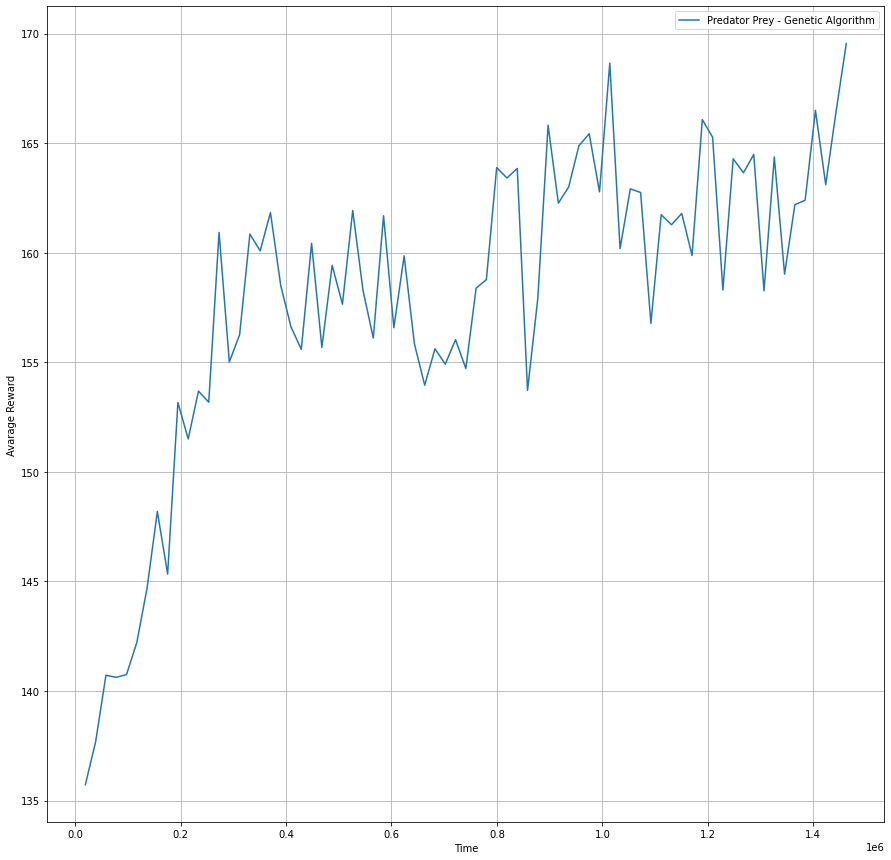

In [644]:
plt.figure(figsize=(15,15))
plt.plot(steps_x, fitness_y, label="Predator Prey - Genetic Algorithm")
plt.xlabel("Time")
plt.ylabel("Avarage Reward")
plt.grid(True)
plt.legend()
plt.show()

In [645]:
models[0]

In [646]:
model_trained = models[0]

## Save model

In [647]:
path_best_model = 'Training/my_model_PP_2'
model_trained.model.save(path_best_model)

INFO:tensorflow:Assets written to: Training/my_model_PP_2\assets


## Load model

In [648]:
path_best_model = 'Training/my_model_PP_2'
model = keras.models.load_model(path_best_model)

In [651]:
obs = env.reset()

In [652]:
'''
0 - direita
1 - esquerda
2 - cima
3 - baixo
'''

obs

array([[0, 0, 2, 2, 2],
       [0, 0, 2, 2, 2],
       [2, 0, 1, 2, 2],
       [2, 2, 0, 2, 0],
       [0, 0, 0, 0, 2]])

In [653]:
print(model_trained(obs.reshape(1, -1)).numpy(), model_trained(obs.reshape(1, -1)).numpy().argmax())

[[0.000000e+00 7.702775e-14 1.000000e+00 0.000000e+00]] 2


In [676]:
env.reset()

array([[2, 0, 0, 0, 2],
       [2, 0, 0, 2, 2],
       [0, 0, 1, 0, 0],
       [2, 2, 0, 2, 2],
       [2, 2, 2, 2, 0]])

In [680]:
[env.action_space.sample() for i in range(10)]

[0, 1, 0, 0, 0, 2, 2, 3, 3, 1]

In [677]:
for i in range(20):
    action = model_trained(obs.reshape(1, -1)).numpy().argmax()
    print(action)
    obs, _, _, _ = env.step(action)
    print(env.array, '\n')
    print(env.get_obs(), '\n')
    print(env.get_neighboors())
    print("-" * 30)

1
[[2 0 0 0 2]
 [2 0 0 2 2]
 [0 1 0 0 0]
 [2 2 0 2 2]
 [2 2 2 2 0]] 

[[2 2 0 0 0]
 [2 2 0 0 2]
 [0 0 1 0 0]
 [2 2 2 0 2]
 [0 2 2 2 2]] 

[0, 0, 0, 2]
------------------------------
1
[[2 0 0 0 2]
 [2 0 0 2 2]
 [1 0 0 0 0]
 [2 2 0 2 2]
 [2 2 2 2 0]] 

[[0 2 2 0 0]
 [2 2 2 0 0]
 [0 0 1 0 0]
 [2 2 2 2 0]
 [2 0 2 2 2]] 

[0, 0, 2, 2]
------------------------------
2
[[2 0 0 0 2]
 [1 0 0 2 2]
 [2 0 0 0 0]
 [2 2 0 2 2]
 [2 2 2 2 0]] 

[[2 0 2 2 2]
 [0 2 2 0 0]
 [2 2 1 0 0]
 [0 0 2 0 0]
 [2 2 2 2 0]] 

[0, 2, 2, 2]
------------------------------
2
[[1 0 0 0 2]
 [2 0 0 2 2]
 [2 0 0 0 0]
 [2 2 0 2 2]
 [2 2 2 2 0]] 

[[2 2 2 2 0]
 [2 0 2 2 2]
 [0 2 1 0 0]
 [2 2 2 0 0]
 [0 0 2 0 0]] 

[0, 2, 2, 2]
------------------------------
2
[[2 0 0 0 2]
 [2 0 0 2 2]
 [2 0 0 0 0]
 [2 2 0 2 2]
 [1 2 2 2 0]] 

[[0 0 2 0 0]
 [2 2 2 2 0]
 [2 0 1 2 2]
 [0 2 2 0 0]
 [2 2 2 0 0]] 

[2, 0, 2, 2]
------------------------------
1
[[2 0 0 0 2]
 [2 0 0 2 2]
 [2 0 0 0 0]
 [2 2 0 2 2]
 [0 2 2 2 1]] 

[[0 0 0 2 0]
 [0 2 2

In [575]:
episodes = 100
avg_total = 0
for ep in range(episodes):
    obs = env.reset().reshape(1, -1)
    done = False
    score = 0
    while not done:
        action = model(obs.reshape(1, -1)).numpy().argmax()
        obs, rew, done, info = env.step(action)
        if render:
            env.render()
        score += rew
    avg_total += score
    print(f"Ep: {ep} || Score: {score}")
print(f"Avg score: {avg_total / episodes}")

Ep: 0 || Score: 766
Ep: 1 || Score: 608
Ep: 2 || Score: 400
Ep: 3 || Score: 296
Ep: 4 || Score: 1181
Ep: 5 || Score: 369
Ep: 6 || Score: 1186
Ep: 7 || Score: 600
Ep: 8 || Score: 540
Ep: 9 || Score: 602
Ep: 10 || Score: 804
Ep: 11 || Score: 1208
Ep: 12 || Score: 804
Ep: 13 || Score: 1072
Ep: 14 || Score: 598
Ep: 15 || Score: 379
Ep: 16 || Score: 607
Ep: 17 || Score: 452
Ep: 18 || Score: 906
Ep: 19 || Score: 1130
Ep: 20 || Score: 296
Ep: 21 || Score: 777
Ep: 22 || Score: 796
Ep: 23 || Score: 785
Ep: 24 || Score: 668
Ep: 25 || Score: 988
Ep: 26 || Score: 864
Ep: 27 || Score: 611
Ep: 28 || Score: 600
Ep: 29 || Score: 489
Ep: 30 || Score: 586
Ep: 31 || Score: 848
Ep: 32 || Score: 982
Ep: 33 || Score: 404
Ep: 34 || Score: 634
Ep: 35 || Score: 596
Ep: 36 || Score: 920
Ep: 37 || Score: 484
Ep: 38 || Score: 1128
Ep: 39 || Score: 961
Ep: 40 || Score: 512
Ep: 41 || Score: 528
Ep: 42 || Score: 770
Ep: 43 || Score: 976
Ep: 44 || Score: 800
Ep: 45 || Score: 591
Ep: 46 || Score: 988
Ep: 47 || Score: 

In [576]:
episodes = 100
avg_total = 0
for ep in range(episodes):
    obs = env.reset().reshape(1, -1)
    done = False
    score = 0
    while not done:
        action = model(obs.reshape(1, -1)).numpy().argmax()
        obs, rew, done, info = env.step(env.action_space.sample())
        if render:
            env.render()
        score += rew
    avg_total += score
    print(f"Ep: {ep} || Score: {score}")
print(f"Avg score: {avg_total / episodes}")

Ep: 0 || Score: 537
Ep: 1 || Score: 469
Ep: 2 || Score: 523
Ep: 3 || Score: 561
Ep: 4 || Score: 660
Ep: 5 || Score: 504
Ep: 6 || Score: 572
Ep: 7 || Score: 513
Ep: 8 || Score: 446
Ep: 9 || Score: 438
Ep: 10 || Score: 688
Ep: 11 || Score: 558
Ep: 12 || Score: 543
Ep: 13 || Score: 561
Ep: 14 || Score: 454
Ep: 15 || Score: 505
Ep: 16 || Score: 496
Ep: 17 || Score: 529
Ep: 18 || Score: 471
Ep: 19 || Score: 417
Ep: 20 || Score: 897
Ep: 21 || Score: 456
Ep: 22 || Score: 451
Ep: 23 || Score: 624
Ep: 24 || Score: 645
Ep: 25 || Score: 601
Ep: 26 || Score: 505
Ep: 27 || Score: 490
Ep: 28 || Score: 530
Ep: 29 || Score: 644
Ep: 30 || Score: 496
Ep: 31 || Score: 521
Ep: 32 || Score: 565
Ep: 33 || Score: 410
Ep: 34 || Score: 388
Ep: 35 || Score: 588
Ep: 36 || Score: 407
Ep: 37 || Score: 653
Ep: 38 || Score: 477
Ep: 39 || Score: 353
Ep: 40 || Score: 613
Ep: 41 || Score: 476
Ep: 42 || Score: 525
Ep: 43 || Score: 464
Ep: 44 || Score: 384
Ep: 45 || Score: 572
Ep: 46 || Score: 497
Ep: 47 || Score: 499
Ep